In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

Fetching reference HEAD


[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 21928.02it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [256]:
from ai2thor.controller import Controller

house = dataset["train"][3]
controller = Controller(scene=house)

In [257]:
import matplotlib.pyplot as plt

event = controller.step("Pass")
event.frame.shape

(300, 300, 3)

In [ ]:
import torch
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import clip
from collections import deque
from PIL import Image


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

ACTIONS = ["MoveAhead", "MoveBack", "RotateRight", "RotateLeft"]
NUM_ACTIONS = len(ACTIONS)

IMG_SIZE = 300  # matches your transform below
GAMMA = 0.99
GAE_LAMBDA = 0.95
PPO_CLIP = 0.2
ENTROPY_COEF = 0.01
VALUE_COEF = 0.5
LR = 3e-4
TRAIN_EPOCHS = 4
MINIBATCHES = 4
ROLLOUT_STEPS = 512      # increase once it runs
MAX_GRAD_NORM = 0.5


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  # -> float in [0,1], shape (3,H,W)
])

# ------------------------ Model (shared encoder) ------------------------
class CNNEncoder(nn.Module):
    """Shape-safe: no hardcoded flatten size; uses GAP -> Linear(feat_dim)."""
    def __init__(self, feat_dim: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 5, 2, padding=2), nn.ReLU(), nn.MaxPool2d(2),  # /4
            nn.Conv2d(32, 64, 5, 1, padding=2), nn.ReLU(), nn.MaxPool2d(2), # /8
            nn.Conv2d(64, 64, 3, 2, padding=1), nn.ReLU(), nn.MaxPool2d(2), # /32
        )
        self.gap  = nn.AdaptiveAvgPool2d((1,1))
        self.proj = nn.Linear(64, feat_dim)

    def forward(self, x):
        if x.ndim == 3:  # (3,H,W) -> (1,3,H,W)
            x = x.unsqueeze(0)
        z = self.conv(x)                # (B,64,h,w)
        z = self.gap(z).squeeze(-1).squeeze(-1)  # (B,64)
        z = self.proj(z)                # (B,feat_dim)
        return z

class Actor(nn.Module):
    def __init__(self, feat_dim, num_actions):
        super().__init__()
        self.head = nn.Linear(feat_dim, num_actions)
    def forward(self, feats):           # (B,feat_dim)
        return self.head(feats)         # logits

class Critic(nn.Module):
    def __init__(self, feat_dim):
        super().__init__()
        self.head = nn.Linear(feat_dim, 1)
    def forward(self, feats):
        return self.head(feats).squeeze(-1)  # (B,)
    

class CLIPNovelty:
    """
    Computes intrinsic reward = 1 - mean cosine similarity
    between current CLIP embedding and last N embeddings.
    """
    def __init__(self, device=DEVICE, model_name="ViT-B/32", buffer_size=100):
        self.device = device
        self.model, self.preprocess = clip.load(model_name, device=device)
        self.buffer = deque(maxlen=buffer_size)

    @torch.no_grad()
    def compute_reward(self, frame_np):
        """
        frame_np : np.ndarray (H,W,3) uint8
        returns : float intrinsic reward
        """
        img = Image.fromarray(frame_np)
        img_t = self.preprocess(img).unsqueeze(0).to(self.device)
        emb = self.model.encode_image(img_t)
        emb = emb / emb.norm(dim=-1, keepdim=True)  # normalize to unit sphere

        if len(self.buffer) == 0:
            self.buffer.append(emb)
            return 0.0  # no past frames to compare yet

        past = torch.cat(list(self.buffer), dim=0)  # (N, D)
        sim = F.cosine_similarity(emb, past)        # (N,)
        reward = (1 - sim.mean()).item()
        self.buffer.append(emb)
        return reward

In [263]:
event = controller.step("Pass")

ACTIONS = ["MoveAhead", "MoveBack", "RotateRight", "RotateLeft"]
feat_dim = 1024
num_actions = len(ACTIONS)

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(300)])

feat_dim = 1024
encoder = CNNEncoder(feat_dim).to(DEVICE)
actor   = Actor(feat_dim, NUM_ACTIONS).to(DEVICE)
critic  = Critic(feat_dim).to(DEVICE)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(actor.parameters()) + list(critic.parameters()),
    lr=LR
)
clip_novelty = CLIPNovelty()

In [264]:
class RolloutBuffer:
    def __init__(self):
        self.obs, self.actions, self.logps = [], [], []
        self.rewards, self.values, self.dones = [], [], []
    def add(self, obs, action_idx, logp, reward, value, done):
        self.obs.append(obs.cpu())              # store CPU to save VRAM
        self.actions.append(int(action_idx))
        self.logps.append(float(logp))
        self.rewards.append(float(reward))
        self.values.append(float(value))
        self.dones.append(bool(done))
    def __len__(self): 
        return len(self.rewards)


In [265]:
def step_env(controller, action_idx):
    action_str = ACTIONS[action_idx]
    event = controller.step(action_str)
    reward = clip_novelty.compute_reward(event.frame)     # your placeholder
    done = False     # plug termination when you add it
    return event, reward, done

def obs_from_event(event):
    frame = event.frame.copy()
    return transform(frame).to(DEVICE)  # (3,H,W) tensor

In [266]:
@torch.no_grad()
def act_and_value(obs_t):               # obs_t: (1,3,H,W)
    feats = encoder(obs_t)
    logits = actor(feats)               # (1, A)
    dist = torch.distributions.Categorical(logits=logits)
    action = dist.sample()              # (1,)
    logp = dist.log_prob(action)        # (1,)
    value = critic(feats)               # (1,)
    return action.item(), logp.item(), value.item()

def evaluate_batch(obs_b, act_b):
    feats = encoder(obs_b)
    logits = actor(feats)
    dist = torch.distributions.Categorical(logits=logits)
    logp = dist.log_prob(act_b)
    entropy = dist.entropy()
    values = critic(feats)
    return logp, entropy, values

In [267]:
def compute_gae(rewards, values, dones, gamma=GAMMA, lam=GAE_LAMBDA):
    T = len(rewards)
    adv = torch.zeros(T, dtype=torch.float32)
    vals = torch.tensor(values + [0.0], dtype=torch.float32)  # bootstrap V_{T}=0 unless you pass last V
    lastgaelam = 0.0
    for t in reversed(range(T)):
        nonterminal = 1.0 - float(dones[t])
        delta = rewards[t] + gamma * vals[t+1] * nonterminal - vals[t]
        lastgaelam = delta + gamma * lam * nonterminal * lastgaelam
        adv[t] = lastgaelam
    ret = adv + vals[:-1]
    return adv, ret

In [268]:
import numpy as np

def ppo_update(buffer: RolloutBuffer):
    T = len(buffer)
    obs = torch.stack(buffer.obs).to(DEVICE)                      # (T,3,H,W)
    actions = torch.tensor(buffer.actions, dtype=torch.long, device=DEVICE)  # (T,)
    old_logps = torch.tensor(buffer.logps, dtype=torch.float32, device=DEVICE)

    advantages, returns = compute_gae(buffer.rewards, buffer.values, buffer.dones)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # minibatching
    idxs = np.arange(T)
    mb_size = max(1, T // MINIBATCHES)

    for _ in range(TRAIN_EPOCHS):
        np.random.shuffle(idxs)
        for start in range(0, T, mb_size):
            mb = idxs[start:start+mb_size]
            mb_obs = obs[mb]
            mb_act = actions[mb]
            mb_old_logp = old_logps[mb]
            mb_adv = advantages[mb].to(DEVICE)
            mb_ret = returns[mb].to(DEVICE)

            new_logp, entropy, value_pred = evaluate_batch(mb_obs, mb_act)

            ratio = torch.exp(new_logp - mb_old_logp)
            surr1 = ratio * mb_adv
            surr2 = torch.clamp(ratio, 1.0 - PPO_CLIP, 1.0 + PPO_CLIP) * mb_adv
            policy_loss = -torch.min(surr1, surr2).mean()

            value_loss = F.mse_loss(value_pred, mb_ret)
            entropy_bonus = entropy.mean()

            loss = policy_loss + VALUE_COEF * value_loss - ENTROPY_COEF * entropy_bonus

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(
                list(encoder.parameters()) + list(actor.parameters()) + list(critic.parameters()),
                MAX_GRAD_NORM
            )
            optimizer.step()


In [269]:
def train(controller, total_updates=10):
    event = controller.step("Pass")  # prime
    for upd in range(total_updates):
        buf = RolloutBuffer()
        # collect rollout
        for t in range(ROLLOUT_STEPS):
            obs_t = obs_from_event(event).unsqueeze(0)  # (1,3,H,W)
            action_idx, logp, value = act_and_value(obs_t)
            event, reward, done = step_env(controller, action_idx)

            # store one step (store obs WITHOUT batch dim to save memory)
            buf.add(obs_t.squeeze(0), action_idx, logp, reward, value, done)

            if t % 100 == 0:
                plt.imshow(obs_t[0].permute(1,2,0))
                plt.show()

            if done:
                event = controller.step("Pass")  # replace with reset/new scene

        ppo_update(buf)
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")

    return buf

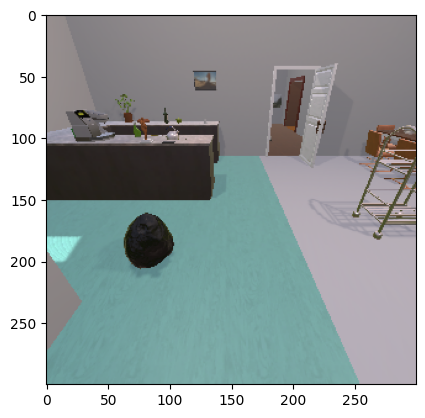

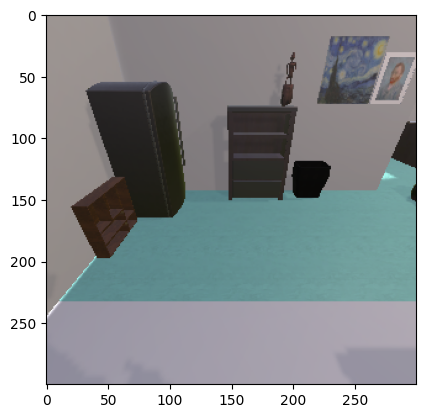

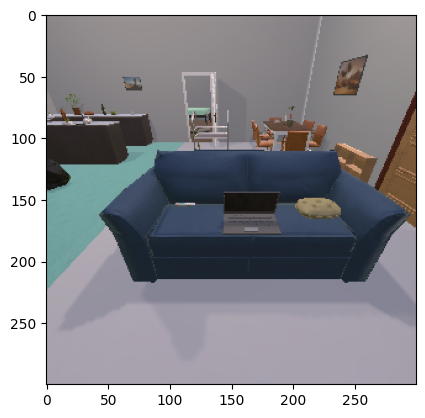

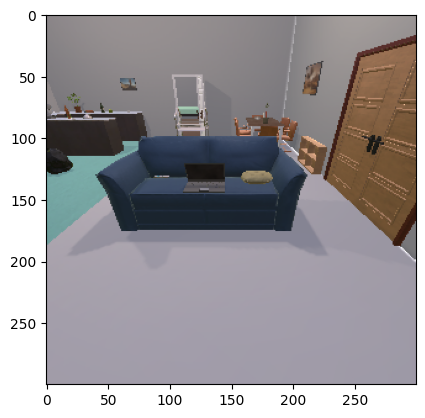

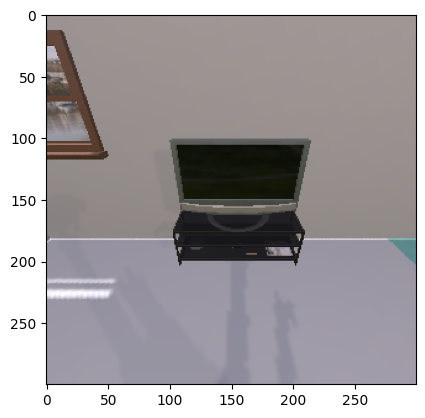

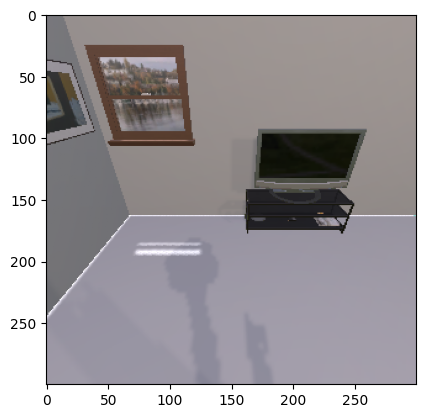

Update 1/10 — steps: 512


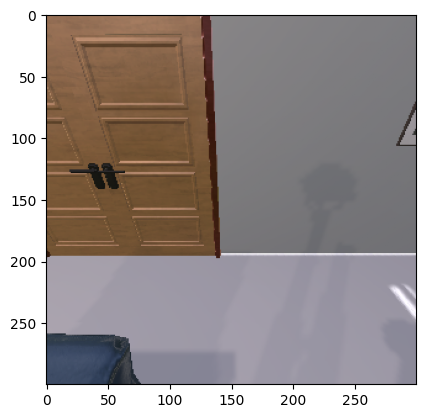

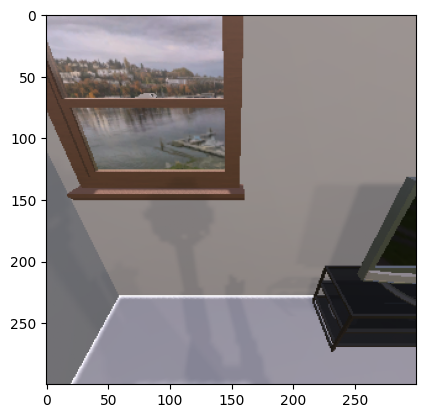

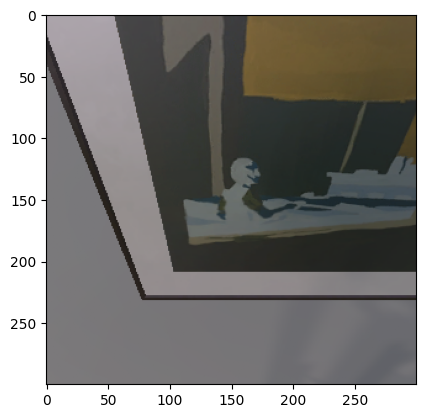

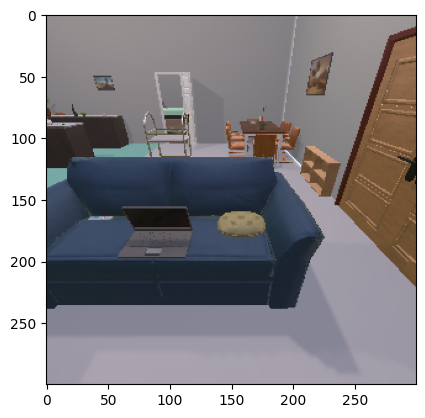

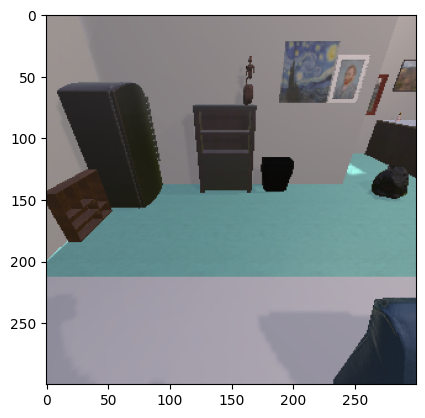

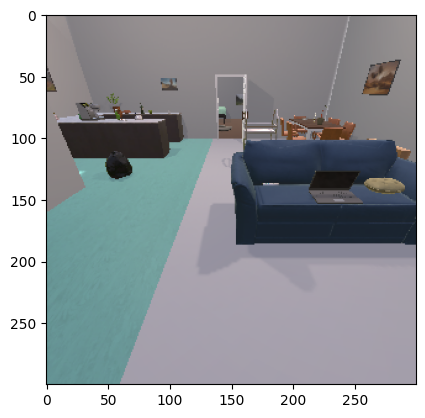

Update 2/10 — steps: 512


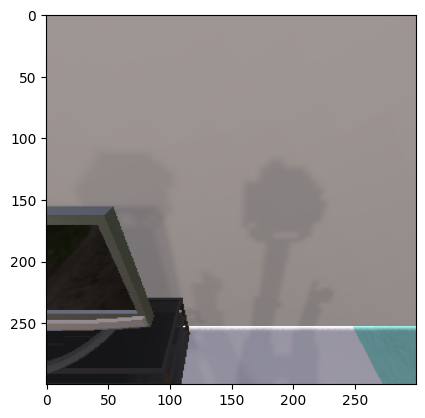

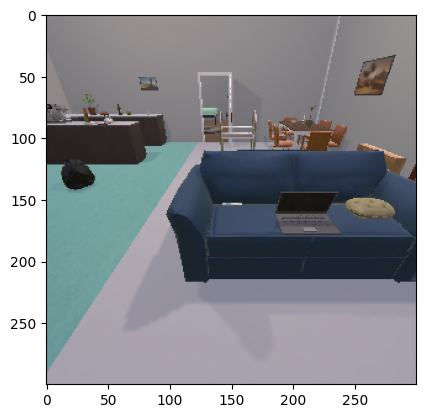

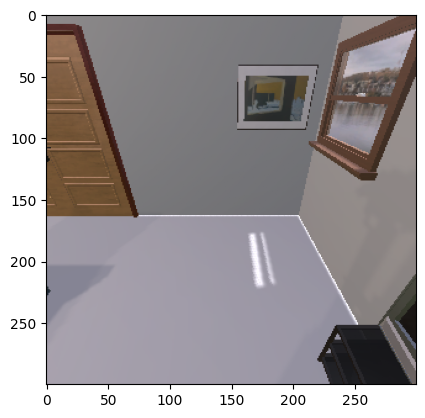

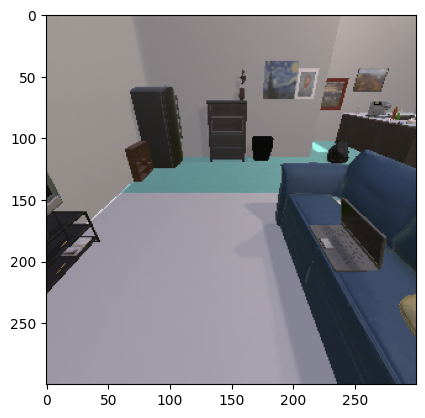

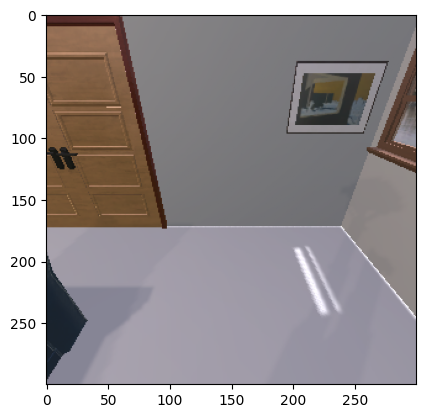

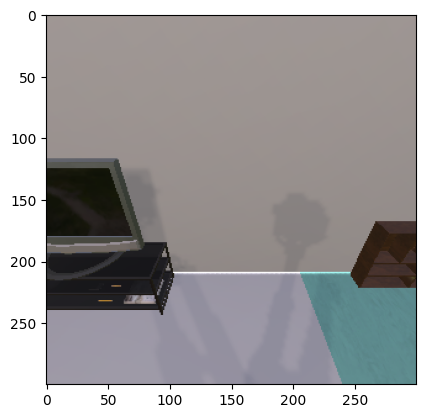

Update 3/10 — steps: 512


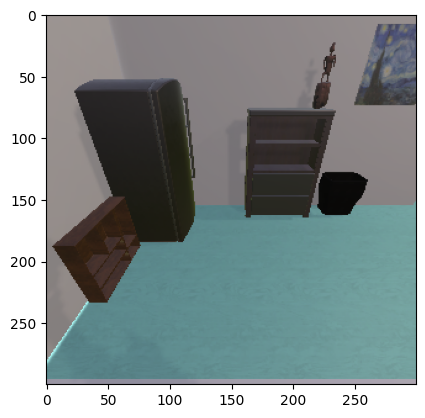

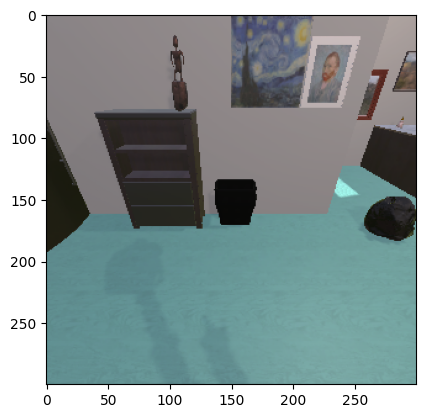

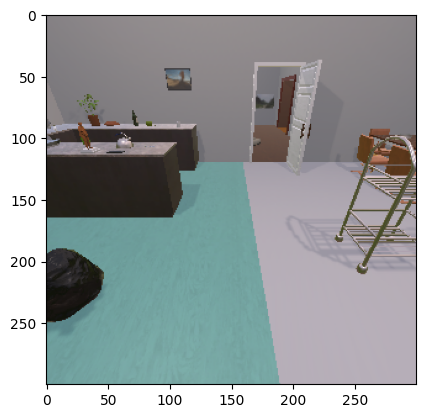

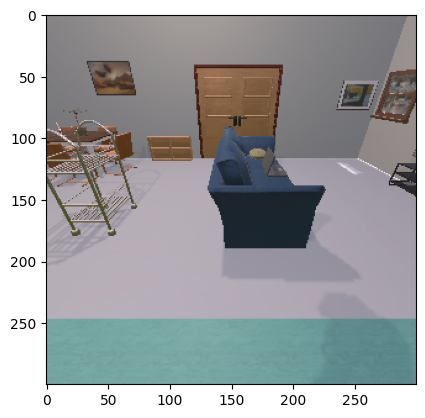

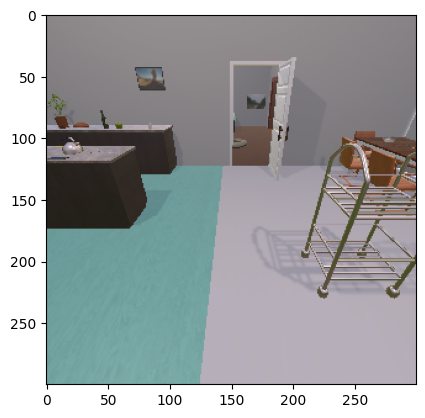

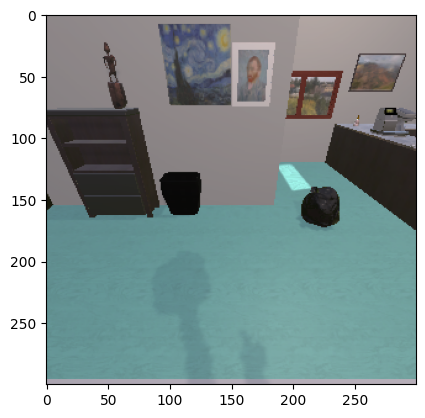

Update 4/10 — steps: 512


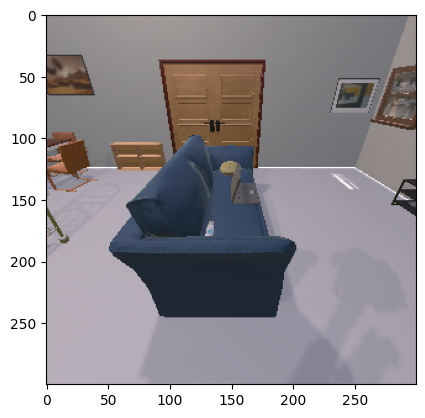

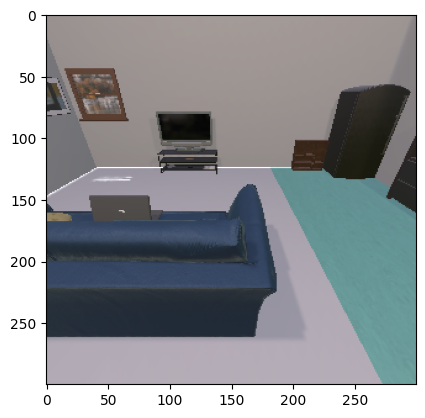

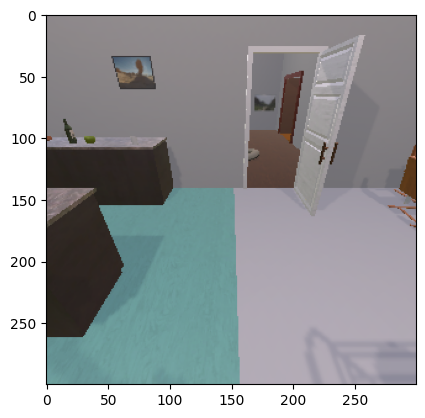

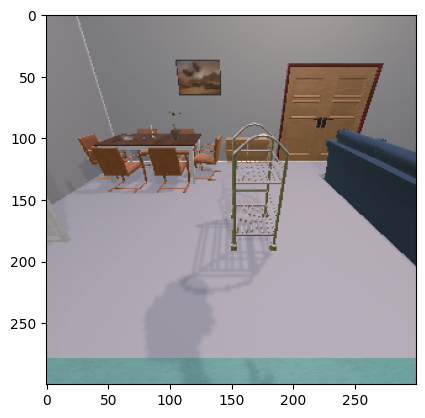

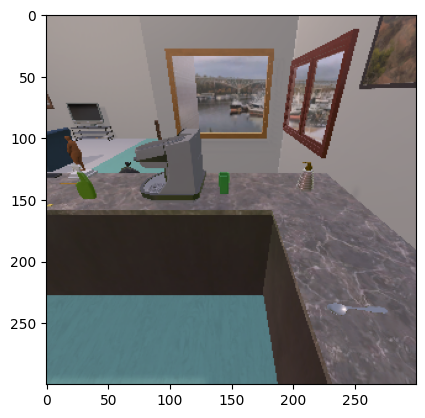

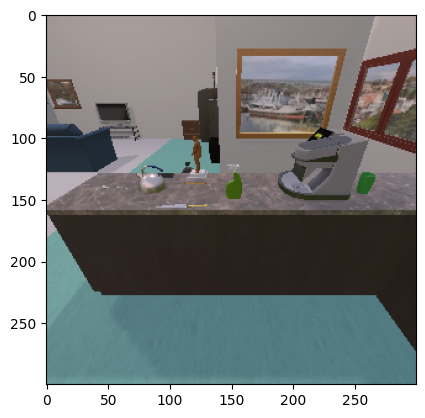

Update 5/10 — steps: 512


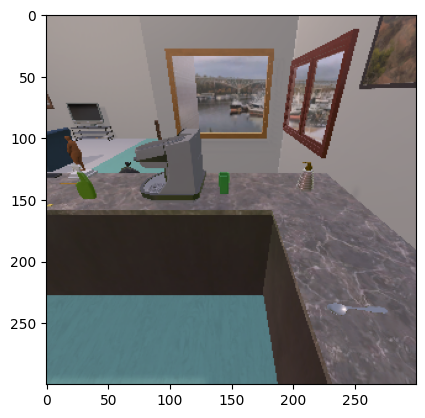

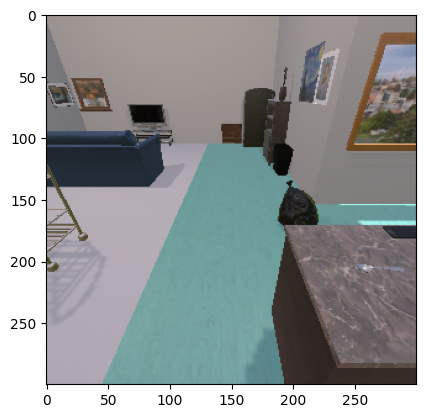

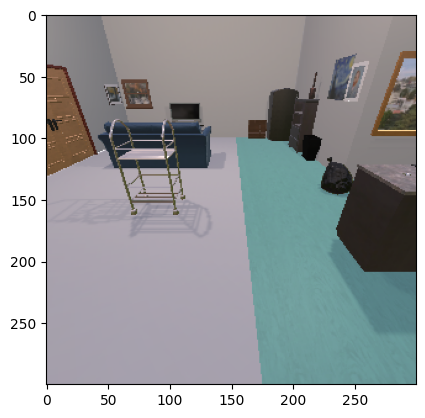

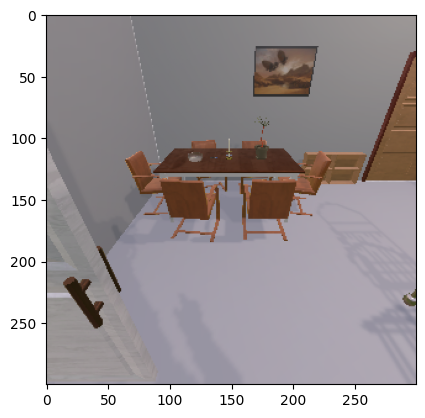

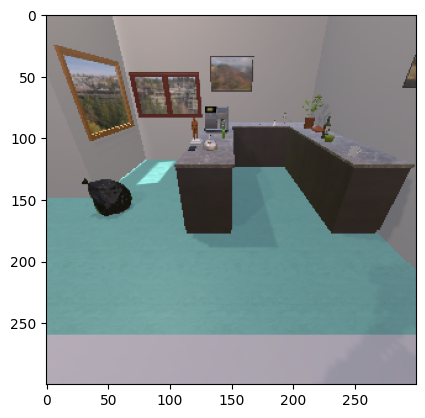

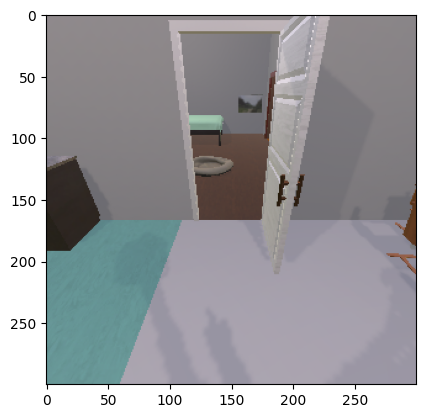

KeyboardInterrupt: 

In [270]:
buf = train(controller)

In [210]:
controller.stop()

BrokenPipeError: [Errno 32] Broken pipe